## Imports

In [16]:
#import pandas as pd 
import numpy as np
import random
from tqdm import tqdm #progres bar
#from itertools import chain

#import matplotlib
import matplotlib.pyplot as plt

from skimage.io import imshow
#from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda # dropout= reduce overfitting
from keras.layers.convolutional import Conv2D, Conv2DTranspose 
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

## Load Data

In [17]:
labels = np.load('data/Images/types.npy')
images = np.load('data/Images/images.npy',allow_pickle=True)
masks = np.load('data/Masks/masks.npy',allow_pickle=True)

print(labels.shape)
print(images.shape)
print(masks.shape)

(2656,)
(2656, 256, 256, 3)
(2656, 256, 256, 6)


In [ ]:
# import matplotlib.image

# for i in tqdm(range(2656)):
#     matplotlib.image.imsave("./data/slice_{0}.png".format(i), images[i,...]/255)

In [18]:
np.unique(labels)

array(['Adrenal_gland', 'Bile-duct', 'Bladder', 'Breast', 'Cervix',
       'Colon', 'Esophagus', 'HeadNeck', 'Kidney', 'Liver', 'Lung',
       'Ovarian', 'Pancreatic', 'Prostate', 'Skin', 'Stomach', 'Testis',
       'Thyroid', 'Uterus'], dtype='<U13')

In [19]:
{i : np.count_nonzero(labels==i) for i in np.unique(labels)}

{'Adrenal_gland': 134,
 'Bile-duct': 159,
 'Bladder': 21,
 'Breast': 827,
 'Cervix': 155,
 'Colon': 478,
 'Esophagus': 155,
 'HeadNeck': 70,
 'Kidney': 37,
 'Liver': 65,
 'Lung': 80,
 'Ovarian': 54,
 'Pancreatic': 78,
 'Prostate': 77,
 'Skin': 59,
 'Stomach': 50,
 'Testis': 60,
 'Thyroid': 80,
 'Uterus': 17}

In [25]:
# Pick a random index for a random image
idx=random.randint(0,2656)

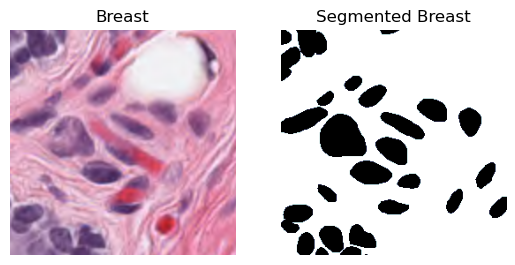

In [26]:
random_img_mask=masks[idx, :, :, 5].astype(int) # Mask (Segmentation)
random_image=images[idx,:,:,:].astype(int) # Image

plt.subplot(1,2,1)
plt.imshow(random_image,cmap='bone')
plt.axis('off')
plt.title(labels[idx])

plt.subplot(1,2,2)
plt.imshow(random_img_mask, cmap='bone')
plt.title("Segmented "+str(labels[idx]))
plt.axis('off')
plt.show()

## IOU Metric Functions  Intersection Over Union

In [27]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Threshold: \tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.numpy_function(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

## Train Test Split

In [28]:
train_idx = np.random.rand(len(images)) < 0.8

In [29]:
train_idx

array([ True,  True,  True, ..., False,  True, False])

In [30]:
train_images = images[train_idx]

train_masks = masks[train_idx]

# train_labels = labels[train_idx]

In [31]:
test_images = images[~train_idx]

test_masks = masks[~train_idx]

# test_labels = labels[~train_idx]

In [32]:
train_images.shape, train_masks.shape, test_images.shape, test_masks.shape

((2145, 256, 256, 3),
 (2145, 256, 256, 6),
 (511, 256, 256, 3),
 (511, 256, 256, 6))

## Build U-Net model

In [33]:
# Each input image is of shape 256 x 256 x 3 (width x height x 3 colour channels - RGB)
inputs = Input((256, 256, 3))

# Input normalization for values between 0 and 1
s = Lambda(lambda x: x / 255) (inputs) 

# Convolutional Layers forming U-Net
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4]) #skip connection
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3]) #skip connection
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2]) #skip connection
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3) #skip connection
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

# Our output is a mask of 128 x 128 (width x height x 1 colour channel - grayscale)
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [34]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[my_iou_metric])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

 conv2d_14 (Conv2D)             (None, 128, 128, 32  18464       ['concatenate_2[0][0]']          
                                )                                                                 
                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 32  0           ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_15[0][0]']              
 spose)   

## Initialize callbacks

In [35]:
# Save model in this path
model_path = "./Segmentation_Unet_Model.h5"

checkpoint = ModelCheckpoint(model_path, monitor="val_loss", mode="min", save_best_only = True, verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, restore_best_weights = True)

In [36]:
# Fit our model 
results = model.fit(train_images, train_masks[:, :, :, 5:], validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystop, checkpoint])

Epoch 1/50
121/121 [==============================] - ETA: 0s - loss: 0.3610 - my_iou_metric: 0.1257
Epoch 1: val_loss improved from inf to 0.31279, saving model to .\Segmentation_Unet_Model.h5
121/121 [==============================] - 520s 4s/step - loss: 0.3610 - my_iou_metric: 0.1257 - val_loss: 0.3128 - val_my_iou_metric: 0.1299
Epoch 2/50
121/121 [==============================] - ETA: 0s - loss: 0.3038 - my_iou_metric: 0.0732
Epoch 2: val_loss improved from 0.31279 to 0.27125, saving model to .\Segmentation_Unet_Model.h5
121/121 [==============================] - 490s 4s/step - loss: 0.3038 - my_iou_metric: 0.0732 - val_loss: 0.2712 - val_my_iou_metric: 0.1172
Epoch 3/50
121/121 [==============================] - ETA: 0s - loss: 0.2957 - my_iou_metric: 0.0664
Epoch 3: val_loss did not improve from 0.27125
121/121 [==============================] - 499s 4s/step - loss: 0.2957 - my_iou_metric: 0.0664 - val_loss: 0.2763 - val_my_iou_metric: 0.1788
Epoch 4/50
121/121 [==============

## Predict on training and validation data

In [37]:
model = load_model('./Segmentation_Unet_Model.h5', custom_objects={'my_iou_metric': my_iou_metric})

In [38]:
# the first 90% was used for training
preds_train = model.predict(train_images[:int(train_images.shape[0]*0.9)], verbose=1)

# the last 10% used as validation
preds_val = model.predict(train_images[int(train_images.shape[0]*0.9):], verbose=1)

#preds_test = model.predict(test_images, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

7/7 [==============================] - 11s 2s/step


In [39]:
# # How Prediction Threshold Works
# p = np.array([[2,3,4], [3,4,5], [4,5,6]])
# (p>3).astype(np.uint8)

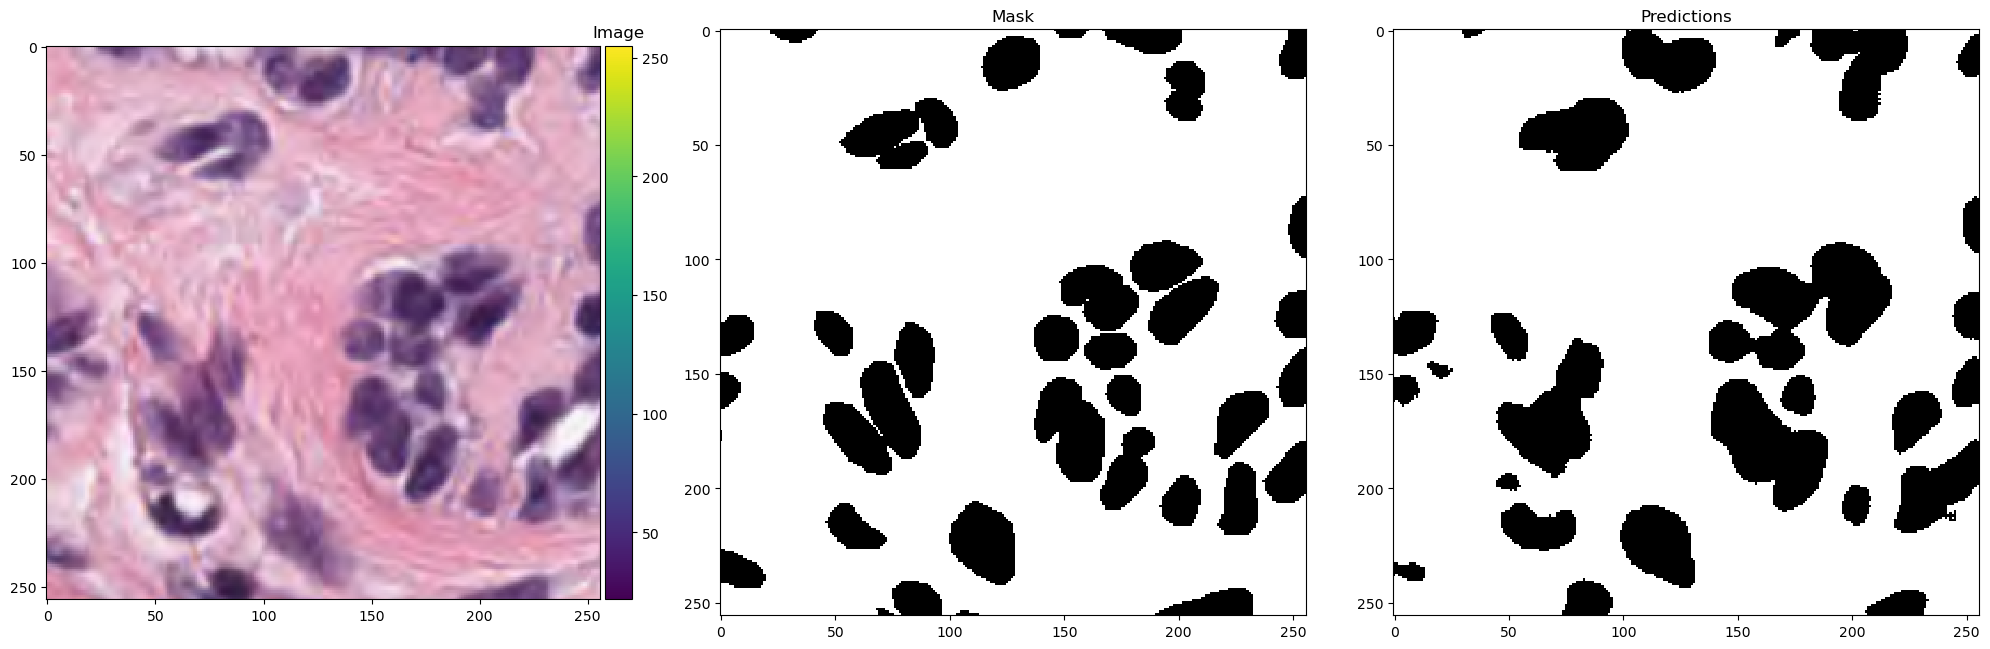

In [47]:
# Ploting predicted masks
ix = random.randint(0, 100) # To pick random train image
plt.figure(figsize=(20,20))

# original training image
plt.subplot(131)
imshow(train_images[ix, :, :, :].astype(int))
plt.title("Image")

# original combined mask  
plt.subplot(132)
imshow(np.squeeze(train_masks[ix, :, :, 5]))
plt.title("Mask")

# U-Net model predicted mask
plt.subplot(133)
imshow(np.squeeze(preds_train_t[ix] > 0.5))
plt.title("Predictions")
plt.show()

## Predict on test data

In [42]:
preds_test = model.predict(test_images, verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

16/16 [==============================] - 28s 2s/step


In [43]:
preds_test_t[0].shape

(256, 256, 1)

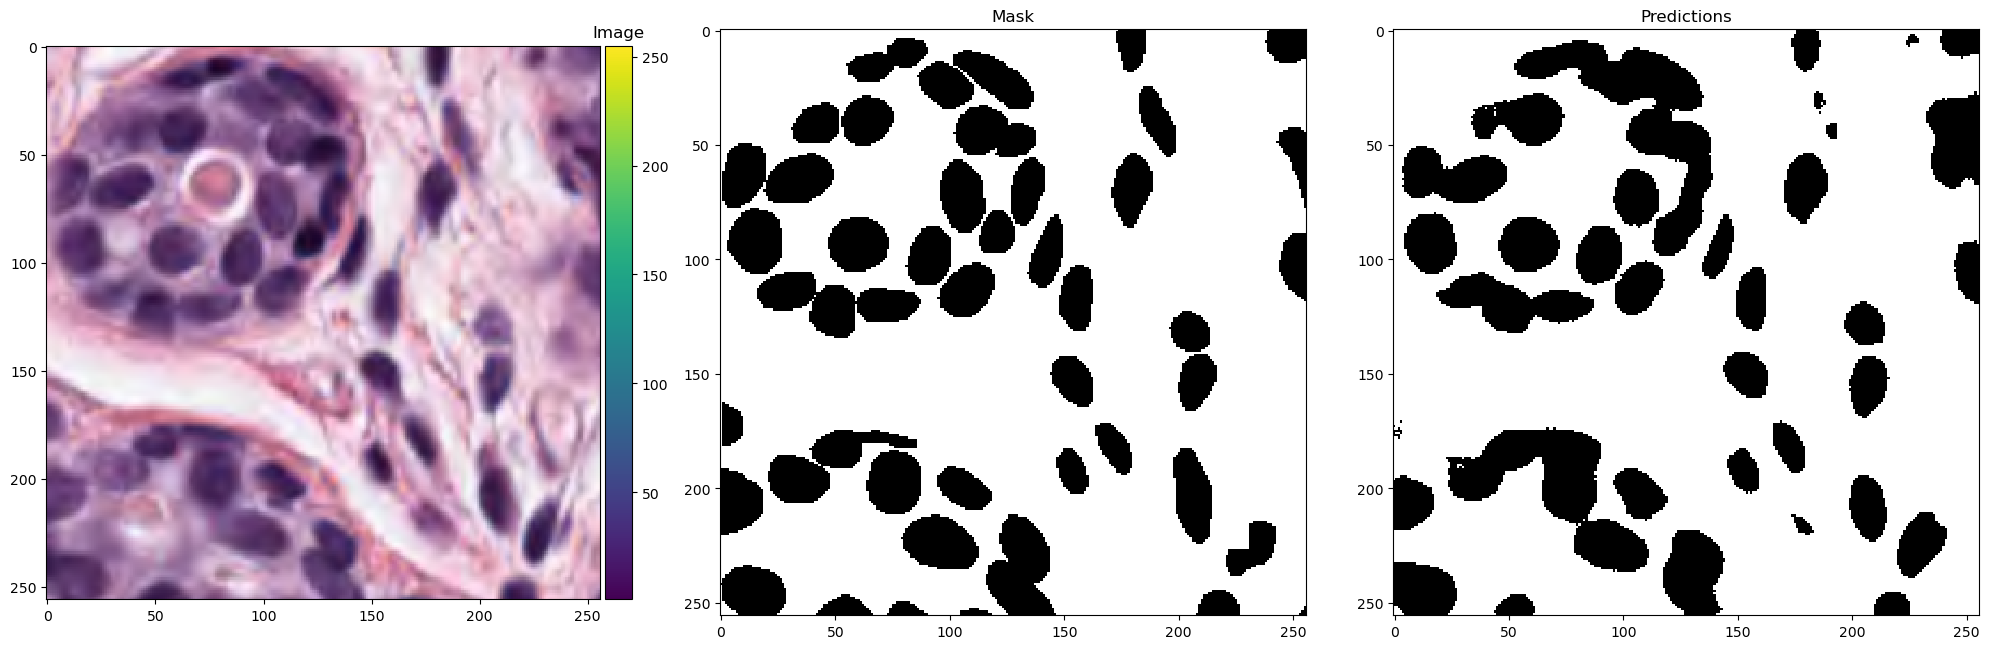

In [45]:
# Ploting predicted masks
ix = random.randint(0, 100) # To pick random test image
plt.figure(figsize=(20,20))

# original training image
plt.subplot(131)
imshow(test_images[ix, :, :, :].astype(int))
plt.title("Image")

# original combined mask  
plt.subplot(132)
imshow(np.squeeze(test_masks[ix, :, :, 5]))
plt.title("Mask")

# U-Net model predicted mask
plt.subplot(133)
imshow(np.squeeze(preds_test_t[ix] > 0.5))
plt.title("Predictions")
plt.show()